<a target="_blank" href="https://colab.research.google.com/drive/1bP4IcpS0QUR6t78HtXiz4nceSqfToLL4?usp=share_link">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [3]:
%%capture
! pip install pip==21.3.1
! pip install ultralytics

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from glob import glob
import numpy as np
import torch
import ultralytics
from ultralytics import YOLO
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image

In [5]:
ultralytics.checks()

Ultralytics YOLOv8.0.53 🚀 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 31.1/166.8 GB disk)


In [6]:
%%shell
cp /content/drive/MyDrive/Reza/Projects/Pedestrian-Detection/data/citypersons.zip .
unzip -q citypersons.zip

In [6]:
# load a pretrained model
model = YOLO('yolov8n.pt')

In [8]:
%%time
# train the model
model.train(data='/content/citypersons/dataset.yaml', epochs=10)

Ultralytics YOLOv8.0.53 🚀 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/citypersons/dataset.yaml, epochs=10, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dy

  0%|          | 0.00/755k [00:00<?, ?B/s]

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.Conv                  [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.Conv                  [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.C2f                   [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.Conv                  [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.C2f                   [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.Conv                  [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.C2f                   [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

CPU times: user 4min 28s, sys: 53.5 s, total: 5min 21s
Wall time: 5min 5s


In [9]:
# evaluate model performance on the validation set
results = model.val()

Ultralytics YOLOv8.0.53 🚀 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/citypersons/valid/labels.cache... 441 images, 10 backgrounds, 0 corrupt: 100%|██████████| 451/451 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.14it/s]
                   all        451       4164      0.616      0.355      0.398      0.233
                 rider        451       1007      0.682      0.218      0.279      0.156
            pedestrian        451       3157       0.55      0.493      0.517       0.31
Speed: 0.3ms preprocess, 2.1ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/detect/val


In [13]:
# helper functions for ploting predictions
def box_label(image, box, label='', color=(128, 128, 128), txt_color=(255, 255, 255)):
  lw = max(round(sum(image.shape) / 2 * 0.003), 2)
  p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
  cv2.rectangle(image, p1, p2, color, thickness=lw, lineType=cv2.LINE_AA)
  if label:
    tf = max(lw - 1, 1)  # font thickness
    w, h = cv2.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]  # text width, height
    outside = p1[1] - h >= 3
    p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
    cv2.rectangle(image, p1, p2, color, -1, cv2.LINE_AA)  # filled
    cv2.putText(image,
                label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2),
                0,
                lw / 3,
                txt_color,
                thickness=tf,
                lineType=cv2.LINE_AA)
    
def plot_bboxes(image, boxes, labels=[], colors=[], score=True, conf=None):
  # Define Labels
  if labels == []:
    labels = {0: u'__background__', 1: u'rider', 2: u'pedestrian'}
  # Define colors
  if colors == []:
    
    colors = [(89, 161, 197), (190, 76, 98), (130, 172, 179), 
              (67, 161, 255),(19, 222, 24),(186, 55, 2),
              (167, 146, 11),(130, 172, 179),(115, 209, 128),
              (204, 79, 135),(136, 126, 185),(209, 213, 45),]              
  
  #plot each boxes
  for box in boxes:
    #add score in label if score=True
    if score :
      label = labels[int(box[-1])+1] + " " + str(round(100 * float(box[-2]),1)) + "%"
    else :
      label = labels[int(box[-1])+1]
    #filter every box under conf threshold if conf threshold setted
    if conf :
      if box[-2] > conf:
        color = colors[int(box[-1])]
        box_label(image, box, label, color)
    else:
      color = colors[int(box[-1])]
      box_label(image, box, label, color)

  #show image
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  try:
    import google.colab
    IN_COLAB = True
  except:
    IN_COLAB = False

  if IN_COLAB:
    cv2_imshow(image) #if used in Colab
  else :
    cv2.imshow(image) #if used in Python


image 1/1 /content/citypersons/valid/images/frankfurt_000001_042384_leftImg8bit.png: 320x640 1 pedestrian, 18.9ms
Speed: 1.5ms preprocess, 18.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


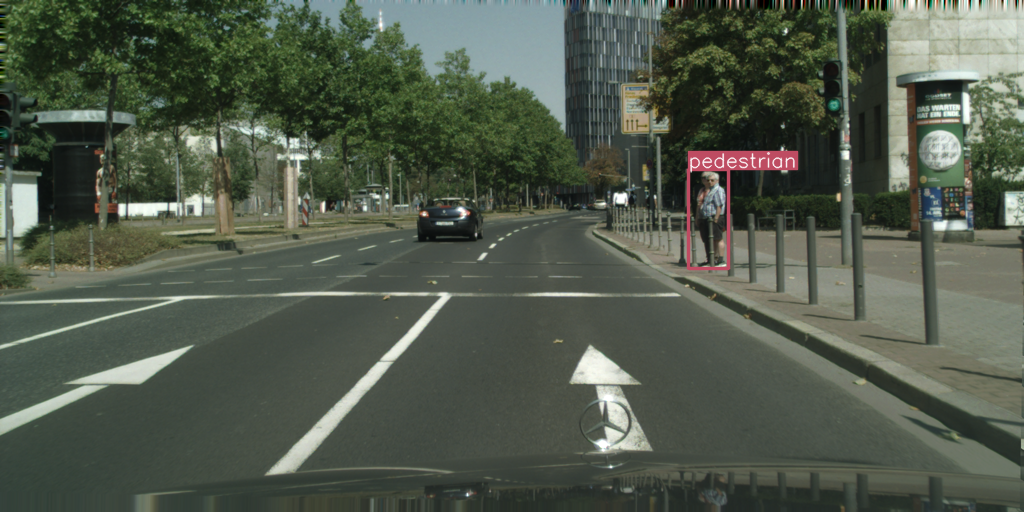


image 1/1 /content/citypersons/valid/images/munster_000151_000019_leftImg8bit.png: 320x640 7 pedestrians, 17.6ms
Speed: 0.6ms preprocess, 17.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


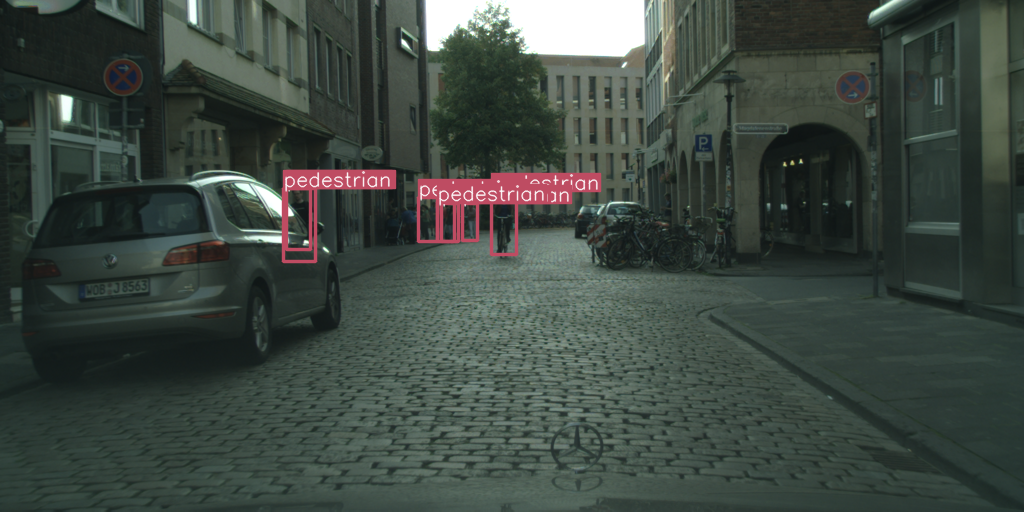


image 1/1 /content/citypersons/valid/images/frankfurt_000001_046126_leftImg8bit.png: 320x640 1 rider, 1 pedestrian, 18.4ms
Speed: 0.5ms preprocess, 18.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


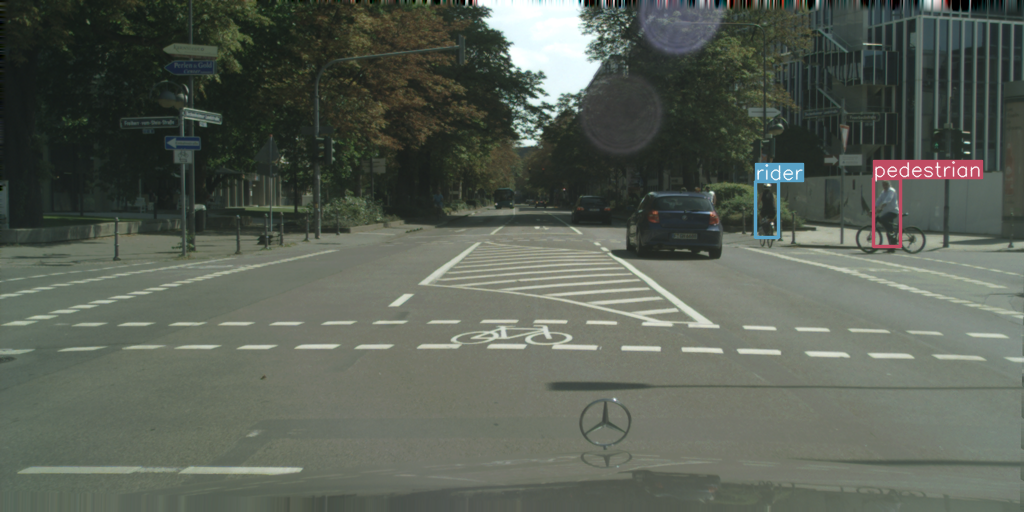


image 1/1 /content/citypersons/valid/images/munster_000072_000019_leftImg8bit.png: 320x640 1 rider, 17.2ms
Speed: 0.5ms preprocess, 17.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


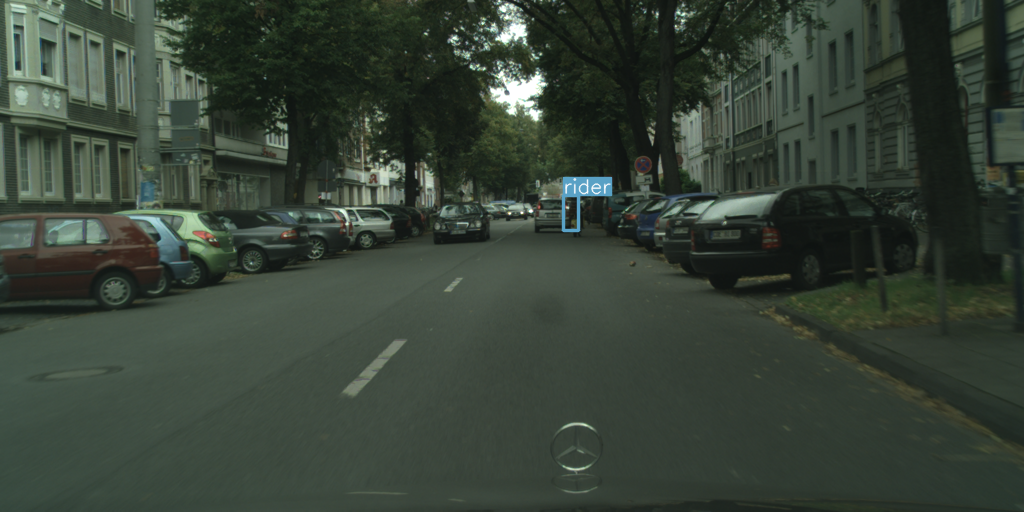


image 1/1 /content/citypersons/valid/images/frankfurt_000001_058914_leftImg8bit.png: 320x640 8 pedestrians, 19.3ms
Speed: 0.6ms preprocess, 19.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


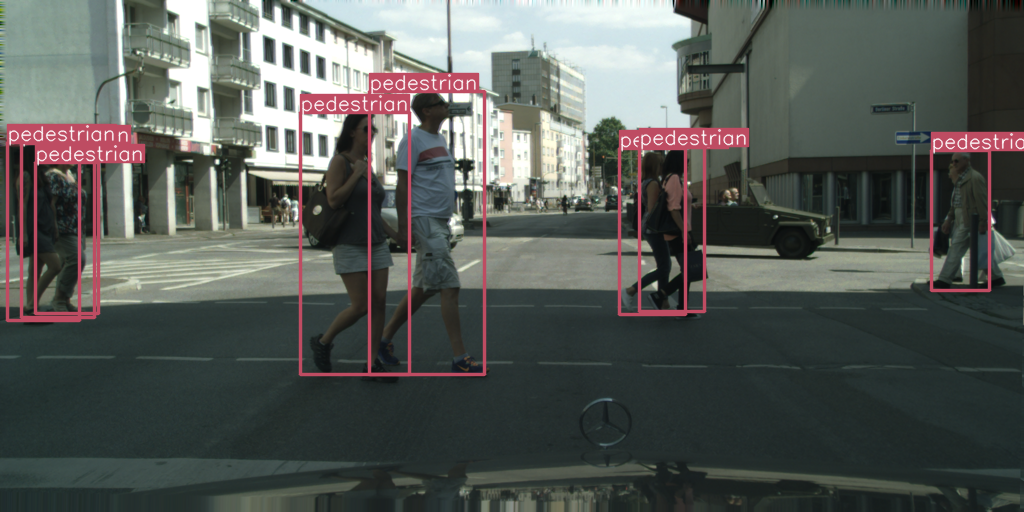

In [14]:
# make prediction on a few validation images and plot the results
valid_images = [fp for fp in glob("/content/citypersons/valid/images/*.png")]

for fp_img in np.random.choice(valid_images, 5):
    preds = model.predict(fp_img);
    image = Image.open(fp_img)
    image = np.asarray(image)
    plot_bboxes(image, preds[0].boxes.boxes, score=False)